In [79]:
import os
import random
import cv2
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
from matplotlib import cm
import random
from tqdm.notebook import tqdm
from scipy.spatial import KDTree

import numpy as np
from scipy.ndimage import maximum_filter, generate_binary_structure
from skimage.feature import peak_local_max

In [80]:
def imregionalmax(image, kernel=None):
    """Find the regional max of the image. An approximation of MATLAB's
    imregionalmax function. Result only differs when surrounding pixels
    have the same value as the center.

    Parameters:
    - image: the input image
    - kernel: the size of the neiborhood region, default is 3x3, i.e.
              neighboring 8 pixels.
    Returns:
    - a bitmask image, where '1' indicates local maxima.
    Author:
    - Yu Fang
    References:
    - https://github.com/bhardwajvijay/Utils/blob/master/utils.cpp
    - https://stackoverflow.com/questions/5550290/find-local-maxima-in-grayscale-image-using-opencv
    """
    # dialate the image so that small values are replaced by local max
    local_max = cv2.dilate(image, kernel)
    # non-local max pixels (excluding pixel w/ constant 3x3 neighborhood)
    # will be replaced by local max, so the values will increase. remove them.
    # so the result is either local max or constant neighborhood.
    max_mask = image >= local_max
    # erode the image so that high values are replaced by local min
    local_min = cv2.erode(image, kernel)
    # only local min pixels and pixels w/ constant 3x3 neighborhood
    # will stay the same, otherwise pixels will be replaced by the local
    # min and become smaller. We only take non-local min, non-constant values.
    min_mask = image > local_min
    # boolean logic hack
    #   (local max || constant) && (!local min && !constant)
    # = local max && !local min && !constant
    # = local max && !constant
    return (max_mask & min_mask).astype(np.uint8)

In [81]:
def anms(cimg, n_best):
    local_max = imregionalmax(cimg)
    coordinates = np.argwhere(local_max)
    
    n_strong = len(coordinates)
    radii = np.full(n_strong, np.inf)
    
    y,x = coordinates[:, 0], coordinates[:, 1]
    c_values = cimg[y,x]

    for i in range(n_strong):
        dist = (x[i] - x)**2 + (y[i] - y)**2
        suppressed_points = c_values[i] < 0.9 * c_values
        suppressed_points[i] = False  # Ignore self-suppression
        if np.any(suppressed_points):
            min_distance = np.min(dist[suppressed_points])
            if min_distance < radii[i]:
                radii[i] = min_distance
    
    sorted_indices = np.argsort(-radii)
    best_indices = sorted_indices[:n_best]
    
    return coordinates[best_indices]


In [82]:
def create_feature_descriptors(image, keypoints, patch_size=40, final_size=8, blur_kernel=(5, 5)):
    descriptors = []
    pad_width = patch_size // 2
    padded_image = cv2.copyMakeBorder(image, pad_width, pad_width, pad_width, pad_width, cv2.BORDER_REFLECT)
    for point in keypoints:
        # Adjust for padding
        x, y = point[1] + pad_width, point[0] + pad_width
        
        # Extract the patch
        patch = padded_image[y-pad_width:y+pad_width, x-pad_width:x+pad_width]
        
        # Apply Gaussian blur
        blurred_patch = cv2.GaussianBlur(patch, blur_kernel, 0)
        
        # Sub-sample
        sub_sampled = blurred_patch[::patch_size//final_size, ::patch_size//final_size]
        
        # Reshape to a vector and standardize
        vector = sub_sampled.flatten()
        vector = (vector - np.mean(vector)) / np.std(vector)
        
        descriptors.append(vector)
        
    return np.array(descriptors)


In [83]:
def match_features(descriptors1, descriptors2, ratio_thresh=0.75):
    matches = []
    # Find the best two matches for each feature in descriptors1
    for i, descriptor1 in enumerate(descriptors1):
        distances = distance.cdist([descriptor1], descriptors2, 'sqeuclidean').flatten()
        if len(distances) < 2:  # Need at least 2 points to proceed
            continue
        
        # Get indices of the sorted distances (best matches first)
        sorted_indices = np.argsort(distances)
        
        # Apply ratio test
        if distances[sorted_indices[0]] < ratio_thresh * distances[sorted_indices[1]]:
            best_match = sorted_indices[0]
            # Perform cross-check: is the best match for the second descriptor also this one?
            distances_back = distance.cdist([descriptors2[best_match]], descriptors1, 'sqeuclidean').flatten()
            if np.argmin(distances_back) == i:
                matches.append(cv2.DMatch(_queryIdx=i, _trainIdx=best_match, _distance=distances[sorted_indices[0]]))
    
    return matches

In [84]:
def est_homography(src, dest):
    """ Compute the homography matrix from (x_src, y_src) to (x_dest, y_dest).
    Parameters:
    - src: (x,y) coordinates of N source pixels, where coordinates are row vectors,
           so the matrix has dimension Nx2 (N>=4).
    - dest: (x,y) coordinates of N destination pixels, where coordinates are row vectors,
            so the matrix has dimension Nx2 (N>=4).
    Returns:
    - the homography matrix such that H @ [x_src, y_src, 1].T = [x_dest, y_dest, 1].T
    Author:
    - Yu Fang
    """
    N = src.shape[0]
    if N != dest.shape[0]:
        raise ValueError("src and diff should have the same dimension")
    src_h = np.hstack((src, np.ones((N, 1))))
    A = np.array([np.block([[src_h[n], np.zeros(3), -dest[n, 0] * src_h[n]],
                            [np.zeros(3), src_h[n], -dest[n, 1] * src_h[n]]])
                  for n in range(N)]).reshape(2 * N, 9)
    [_, _, V] = np.linalg.svd(A)
    # take the right singular vector x corresponding to the least singular value
    # s.t. ||Ax - 0||^2 is minimized
    return V.T[:, 8].reshape(3, 3)

def apply_homography(H, src):
    """ Apply the homography H to src
    Parameters:
    - H: the 3x3 homography matrix
    - src: (x,y) coordinates of N source pixels, where coordinates are row vectors,
           so the matrix has dimension Nx2 (N>=4).
    Returns:
    - src: (x,y) coordinates of N destination pixels, where coordinates are row vectors,
           so the matrix has dimension Nx2 (N>=4).
    Author:
    - Yu Fang
    """
    src_h = np.hstack((src, np.ones((src.shape[0], 1))))
    dest =  src_h @ H.T
    return (dest / dest[:,[2]])[:,0:2]

In [85]:
def drawMatches(image1, kp1, image2, kp2, idx_pairs):
    """A wrapper around OpenCV's drawMatches.
    
    Parameters:
    - image1: the first image
    - kp1: *matrix indices* of the keypoints from image 1
           (Nx2 numpy array, where N is the number of keypoints)
    - image2: the second image
    - kp2: *matrix indices* of the keypoints from image 2 
           (Nx2 numpy array, where N is the number of keypoints)
    - idx_pairs: pairs of matching indices, e.g. if kp1[3] 
                 matches kp2[5], then idx_pairs=[[3,5],...]
                 (Kx2 numpy array, where K is the number of matches)
    Returns:
    - an image showing matching points
    Author:
    - Yu Fang
    """
    # note that the coordinates are reversed because the difference
    # between matrix indexing & coordinates.
    keypt1 = [cv2.KeyPoint(coord[1], coord[0], 40) for coord in kp1.tolist()]
    keypt2 = [cv2.KeyPoint(coord[1], coord[0], 40) for coord in kp2.tolist()]
    matches = [cv2.DMatch(pair[0], pair[1], 0) for pair in idx_pairs.tolist()]
    return cv2.drawMatches(image1, keypt1, image2, keypt2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

In [86]:
def crop_dark(panorama):
    gray_panorama = cv2.cvtColor(panorama, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray_panorama, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_area_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(max_area_contour)
    panorama = panorama[y:y+h, x:x+w]

    return panorama


def find_homography_ransac(src, dest, threshold=0.5, max_iterations=1000):
    """
    Run RANSAC to estimate H.
    Input:
    - src, dest: coordinates
    - threshold: threshold for RANSAC
    - max_iterations: number of iterations for RANSAC
    Output:
    - estimated homography H
    - inliers
    """
    max_inliers_count = 0
    best_H = None
    best_inliers = None
    if src.shape[0] < 4 or dest.shape[0] < 4:
        print(src.shape[0],dest.shape[0])
        raise ValueError("Not enough points to calculate homography. There must be at least 4 points.")
    for _ in range(max_iterations):
        indices = random.sample(range(src.shape[0]), 4)
        src_sample = src[indices]
        dest_sample = dest[indices]

        H = est_homography(src_sample, dest_sample)
        dest_estimated = apply_homography(H, src)

        distances = np.linalg.norm(dest_estimated - dest, axis=1)
        inliers = distances < threshold
        inliers_count = np.sum(inliers)

        if inliers_count > max_inliers_count:
            best_H = H
            best_inliers = inliers
            max_inliers_count = inliers_count
        
        if np.sum(inliers) / len(inliers) * 100 > 90:
            break

    if best_H is not None and max_inliers_count >= 4:
        src_inliers = src[best_inliers]
        dest_inliers = dest[best_inliers]
        # Re-estimate homography with all inliers
        best_H = est_homography(src_inliers, dest_inliers)
        # Normalize the homography matrix
        best_H = best_H / best_H[2, 2] if best_H[2, 2] != 0 else best_H
    else:
        raise ValueError("RANSAC was unable to find a valid homography for the given set of points.")
    
    return best_H, best_inliers

In [87]:
def stitch_images(img1, img2, match_thresh=0.7, error_thresh=0.5):
    """
    Stitch two images at a time.
    Inputs:
    - img1, img2 with shape [H, W, 3].
    Output:
    - stitched_image with shape [H, W, 3].
    """
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    dst1 = cv2.cornerHarris(gray1, blockSize=2, ksize=3, k=0.04)
    n_best_coordinates1 = anms(dst1, 1000)
    descriptors1 = create_feature_descriptors(gray1, n_best_coordinates1)
    
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    dst2 = cv2.cornerHarris(gray2, blockSize=2, ksize=3, k=0.04)
    n_best_coordinates2 = anms(dst2, 1000)
    descriptors2 = create_feature_descriptors(gray2, n_best_coordinates2)
    
    keypoints1 = [cv2.KeyPoint(x=float(x), y=float(y), size=20) for y, x in n_best_coordinates1]
    keypoints2 = [cv2.KeyPoint(x=float(x), y=float(y), size=20) for y, x in n_best_coordinates2]
    
    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2, None)
    
    matches = match_features(descriptors1, descriptors2, ratio_thresh= 0.45)
    
    stitched_image = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(stitched_image)
    
    points1 = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 2)
    points2 = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 2)
    
    H, best_inliers = find_homography_ransac(points2, points1)
    
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # Find the bounds of the new image after warping img2
    corners2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
    corners2_transformed = cv2.perspectiveTransform(corners2, H)
    all_corners = np.vstack((corners2_transformed, np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)))

    [x_min, y_min] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

    translation_dist = [-x_min, -y_min]

    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

    # Warp img2 to the plane of img1
    stitched_image = cv2.warpPerspective(img2, H_translation.dot(H), (x_max-x_min, y_max-y_min))
    stitched_image[translation_dist[1]:h1+translation_dist[1], translation_dist[0]:w1+translation_dist[0]] = img1

    return stitched_image

### Step 1: Corner Detection

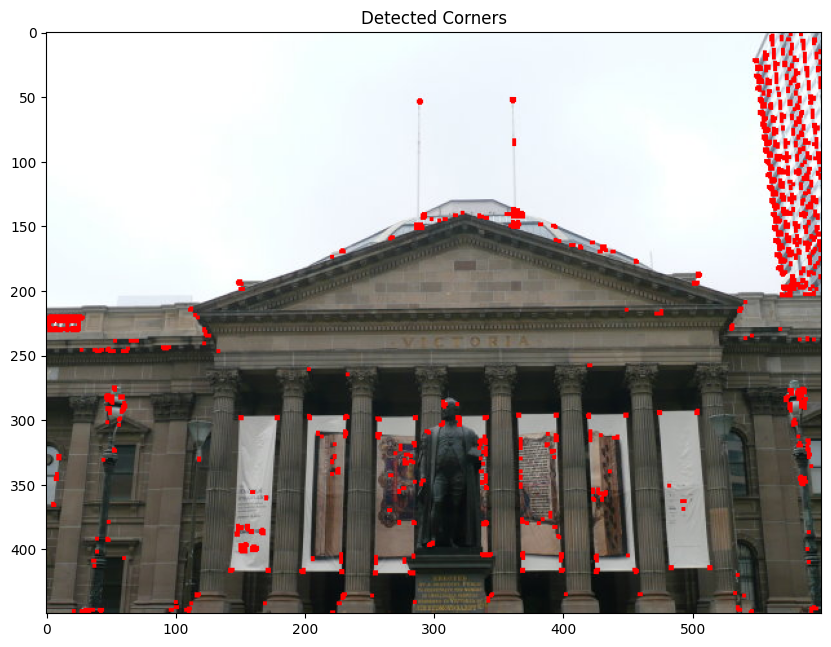

In [88]:
img_list = ["../images/input/set1/1.jpg","../images/input/set1/2.jpg","../images/input/set1/3.jpg"]
img1 = cv2.imread(img_list[0])

# Convert it to grayscale
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

# Apply Harris corner detector
dst1 = cv2.cornerHarris(gray1, blockSize=2, ksize=3, k=0.04)

# Result is dilated for marking the corners, not important
dst1_dilated = cv2.dilate(dst1, None)

# Threshold for an optimal value, it may vary depending on the image
threshold = 0.01 * dst1_dilated.max()

# Create a copy of the original image to draw corners on
img1_corners = img1.copy()

# Draw the corners on the image
img1_corners[dst1_dilated > threshold] = [0, 0, 255]  # Red color

# Convert the BGR image to RGB for displaying in matplotlib
img1_corners_rgb = cv2.cvtColor(img1_corners, cv2.COLOR_BGR2RGB)

# Now display the image with detected corners
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(img1_corners_rgb)
plt.title('Detected Corners')
plt.show()


### Step 2: ANMS

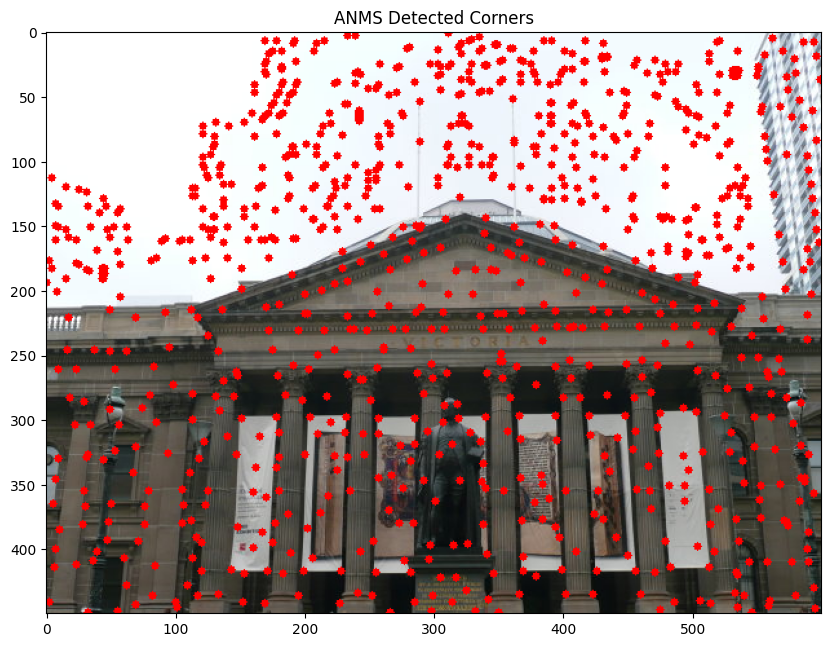

In [89]:
n_best_coordinates1 = anms(dst1, 1000)

# Create a copy of the original image to draw corners on
img1_with_anms = img1.copy()

# Draw the corners on the image
for y, x in n_best_coordinates1:
    cv2.circle(img1_with_anms, (int(x), int(y)), radius=3, color=(0, 0, 255), thickness=-1)  # Red color for the corners

# Convert the BGR image to RGB for displaying in matplotlib
img1_with_anms_rgb = cv2.cvtColor(img1_with_anms, cv2.COLOR_BGR2RGB)

# Now display the image with ANMS corners
plt.figure(figsize=(10, 10))
plt.imshow(img1_with_anms_rgb)
plt.title('ANMS Detected Corners')
plt.show()


### Step 3: Feature Description

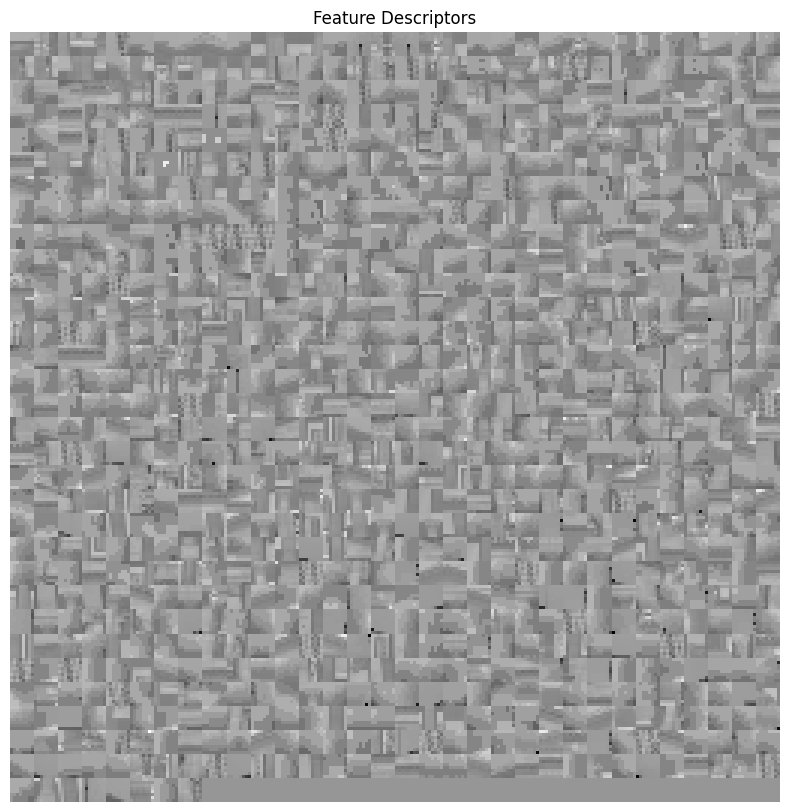

In [90]:
# Feature descriptor + Visualisation

descriptors1 = create_feature_descriptors(gray1, n_best_coordinates1)

# Number of descriptors along the width and height of the visualization grid
grid_size = int(np.ceil(np.sqrt(len(descriptors1))))

final_size = 8

# Initialize a blank image to place the descriptors
descriptor_vis = np.zeros((grid_size * final_size, grid_size * final_size))

# Fill in the visualization image with descriptor patches
for idx, desc in enumerate(descriptors1):
    # Find the position in the grid
    row = idx // grid_size
    col = idx % grid_size
    
    # Reshape the 1D descriptor back into the 2D patch
    patch = desc.reshape((final_size, final_size))
    
    # Place it in the descriptor visualization image
    descriptor_vis[row * final_size:(row + 1) * final_size, 
                   col * final_size:(col + 1) * final_size] = patch

# Normalize the visualization image for display
descriptor_vis = cv2.normalize(descriptor_vis, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

# Display the descriptor visualization image
plt.figure(figsize=(10, 10))
plt.imshow(descriptor_vis, cmap='gray')
plt.title('Feature Descriptors')
plt.axis('off')  # Hide the axes for better visualization
plt.show()

### Step 4: Feature Matching

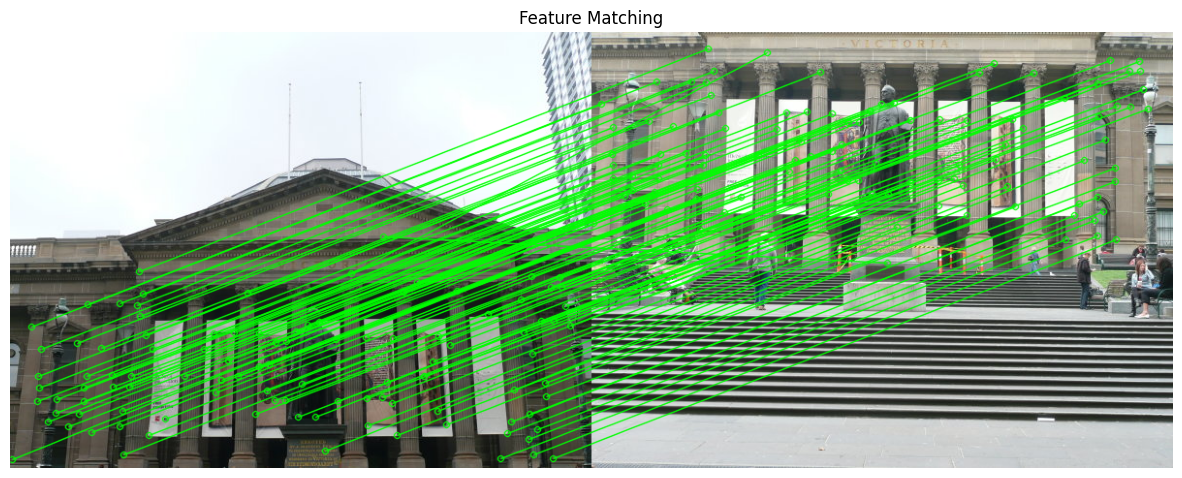

In [91]:

img2 = cv2.imread(img_list[1]) 
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
dst2 = cv2.cornerHarris(gray2, blockSize=2, ksize=3, k=0.04)
n_best_coordinates2 = anms(dst2, 1000)
descriptors2 = create_feature_descriptors(gray2, n_best_coordinates2)

keypoints1 = [cv2.KeyPoint(x=float(x), y=float(y), size=20) for y, x in n_best_coordinates1]
keypoints2 = [cv2.KeyPoint(x=float(x), y=float(y), size=20) for y, x in n_best_coordinates2]

matches = match_features(descriptors1, descriptors2, ratio_thresh= 0.4)

matched_img = cv2.drawMatches(
    img1, keypoints1, img2, keypoints2, matches, None, flags=2,
    matchColor=(0, 255, 0)  # Draw matches in green color
)

# Convert BGR image to RGB for matplotlib display
matched_img_rgb = cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(15, 10))
plt.imshow(matched_img_rgb)
plt.title('Feature Matching')
plt.axis('off')  # Hide the axes for better visualization
plt.show()

### Step 5: Refine RANSAC + Homography

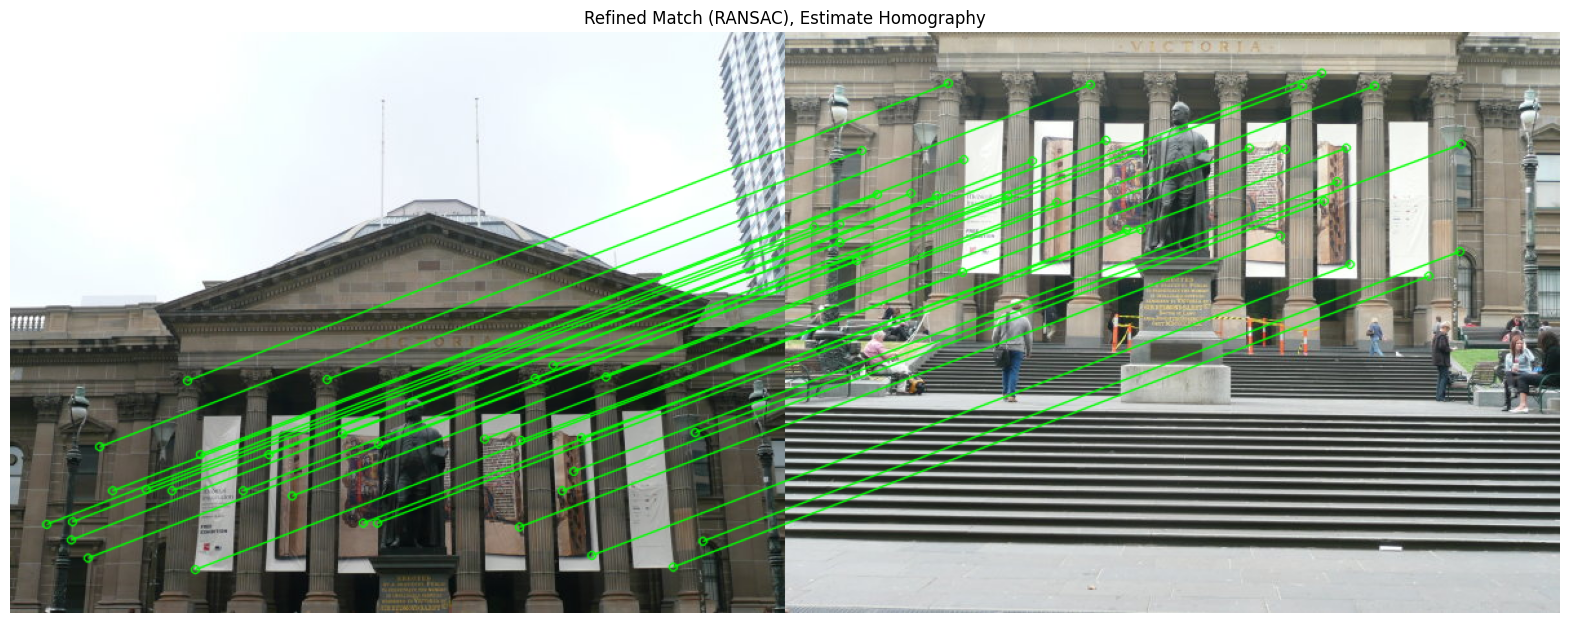

In [92]:

points1 = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 2)
points2 = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 2)

H, best_inliers = find_homography_ransac(points2, points1)

# After finding the homography, H, and the inliers, best_inliers, use them to filter the matches
inlier_matches = [matches[i] for i in range(len(matches)) if best_inliers[i]]

# Now draw only the inlier matches with cv2.drawMatches
# Note: You will need to have the img1 and img2, and their corresponding keypoints from your previous steps
inlier_match_img = cv2.drawMatches(
    img1, keypoints1, img2, keypoints2, inlier_matches, None, flags=2,
    matchColor=(0, 255, 0)  # Green color for inlier matches
)

# Convert BGR image to RGB for matplotlib display
inlier_match_img_rgb = cv2.cvtColor(inlier_match_img, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(20, 10))
plt.imshow(inlier_match_img_rgb)
plt.title('Refined Match (RANSAC), Estimate Homography')
plt.axis('off')  # Hide the axes for better visualization
plt.show()


In [93]:
def determine_position(image1, image2):

    sift = cv2.SIFT_create()

    keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(descriptors1, descriptors2, k=2)
    matchesMask = [[0,0] for i in range(len(matches))]

    good = []
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.7*n.distance:
            good.append(m)
            matchesMask[i]=[1,0]

    if len(good) > 0:
        src_pts = np.float32([ keypoints1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ keypoints2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

        x_differences = [src[0][0] - dst[0][0] for src, dst in zip(src_pts, dst_pts)]
        avg_diff = sum(x_differences) / len(x_differences)

        if avg_diff > 0:
            return "left"
        else:
            return "right"

In [94]:
### MAIN BODY ###
img_list1 = ["../images/input/set1/1.jpg","../images/input/set1/2.jpg","../images/input/set1/3.jpg"]
img_list2 = ["../images/input/set2/1.jpg","../images/input/set2/2.jpg","../images/input/set2/3.jpg"]
img_list3 = ["../images/input/set3/1.jpg","../images/input/set3/2.jpg","../images/input/set3/3.jpg","../images/input/set3/4.jpg"]
    
def stitch_all(img_list):
    blended_image = cv2.imread(img_list[0])
    for i in range(1, len(img_list)):
        img2 = cv2.imread(img_list[i])
        position = determine_position(blended_image, img2)
        if position == 'right':
            img1 = blended_image
        else:
            img1 = img2
            img2 = blended_image
            
        blended_image = stitch_images(img1, img2)
        plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

    return blended_image

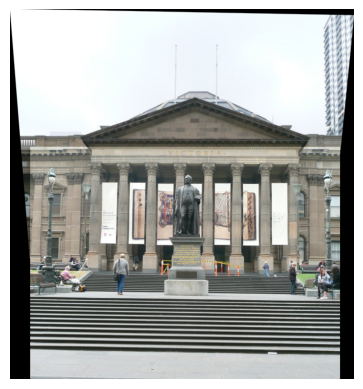

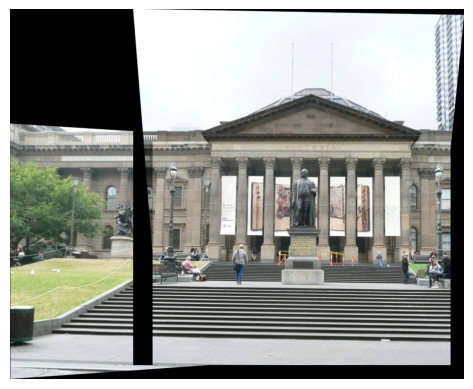

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[ 49,  48,  47],
        [226, 220, 215],
        [225, 219, 214],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[ 49,  48,  47],
        [224, 218, 213],
        [224, 218, 213],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[ 41,  40,  39],
        [170, 165, 161],
        [161, 157, 153],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [95]:
stitch_all(img_list1)

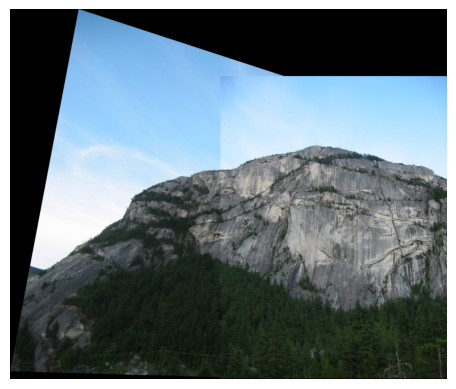

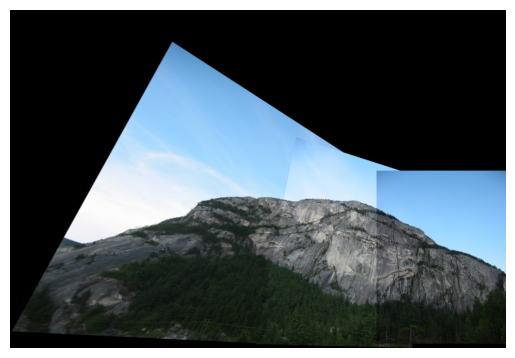

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [96]:
stitch_all(img_list2)

C:\Users\guokw\AppData\Local\Temp\ipykernel_42980\2349139586.py:20: RuntimeWarning: invalid value encountered in divide
  vector = (vector - np.mean(vector)) / np.std(vector)


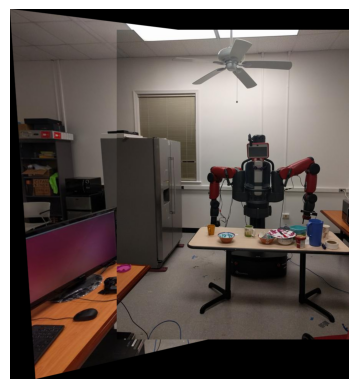

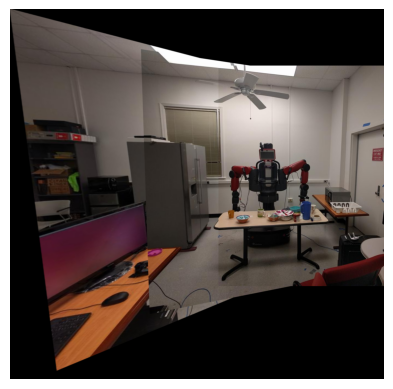

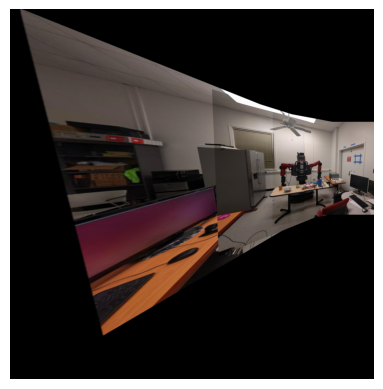

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [97]:
stitch_all(img_list3)

### Main Body Code for all 3 datasets

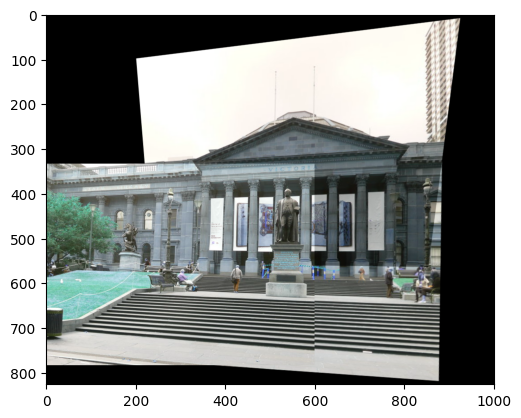

In [100]:
# SET 1

img_list = ["../images/input/set1/1.jpg","../images/input/set1/2.jpg","../images/input/set1/3.jpg"]
img1 = cv2.imread(img_list[0])
img2 = cv2.imread(img_list[1]) 
img3 = cv2.imread(img_list[2]) 

stitched_12 = stitch_images(img1,img2)
stitched_123 = stitch_images(img3, stitched_12)
plt.imshow(stitched_123)

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


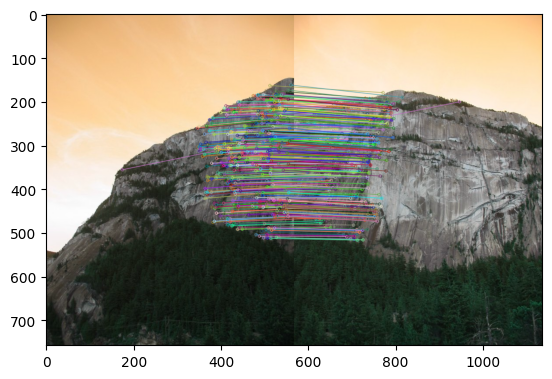

In [ ]:
# SET 2

img_list = ["../images/input/set2/1.jpg","../images/input/set2/2.jpg","../images/input/set2/3.jpg"]
img1 = cv2.imread(img_list[0])
img2 = cv2.imread(img_list[1]) 
img3 = cv2.imread(img_list[2]) 

stitched_12 = stitch_images(img1,img2)
stitched_123 = stitch_images(img3,stitched_12)
plt.imshow(stitched_123)

In [102]:
# SET 3

img_list = ["../images/input/set3/1.jpg","../images/input/set3/2.jpg","../images/input/set3/3.jpg","../images/input/set3/4.jpg"]
img1 = cv2.imread(img_list[0])
img2 = cv2.imread(img_list[1]) 
img3 = cv2.imread(img_list[2]) 
img4 = cv2.imread(img_list[3]) 

stitched_12 = stitch_images(img3,img2)
stitched_123 = stitch_images(img1,stitched_12)
stitched_1234 = stitch_images(img4,stitched_123)
plt.imshow(stitched_123)

C:\Users\guokw\AppData\Local\Temp\ipykernel_42980\2349139586.py:20: RuntimeWarning: invalid value encountered in divide
  vector = (vector - np.mean(vector)) / np.std(vector)
